<a href="https://colab.research.google.com/github/Ramesh-Arvind/BP-Estimation-using-CNN/blob/main/BikeSharingAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pmdarima
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.0 MB/s eta 0:00:00


Shape of data (17379, 17)
Number of missing value 0
              count         mean          std   min        25%        50%  \
instant     17379.0  8690.000000  5017.029500  1.00  4345.5000  8690.0000   
season      17379.0     2.501640     1.106918  1.00     2.0000     3.0000   
yr          17379.0     0.502561     0.500008  0.00     0.0000     1.0000   
mnth        17379.0     6.537775     3.438776  1.00     4.0000     7.0000   
hr          17379.0    11.546752     6.914405  0.00     6.0000    12.0000   
holiday     17379.0     0.028770     0.167165  0.00     0.0000     0.0000   
weekday     17379.0     3.003683     2.005771  0.00     1.0000     3.0000   
workingday  17379.0     0.682721     0.465431  0.00     0.0000     1.0000   
weathersit  17379.0     1.425283     0.639357  1.00     1.0000     1.0000   
temp        17379.0     0.496987     0.192556  0.02     0.3400     0.5000   
atemp       17379.0     0.475775     0.171850  0.00     0.3333     0.4848   
hum         17379.0     

<ipython-input-4-6cf1d2f2ad37>:37: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preprocessed_data['registered'], label='registered')
<ipython-input-4-6cf1d2f2ad37>:38: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preprocessed_data['casual'], label='casual')


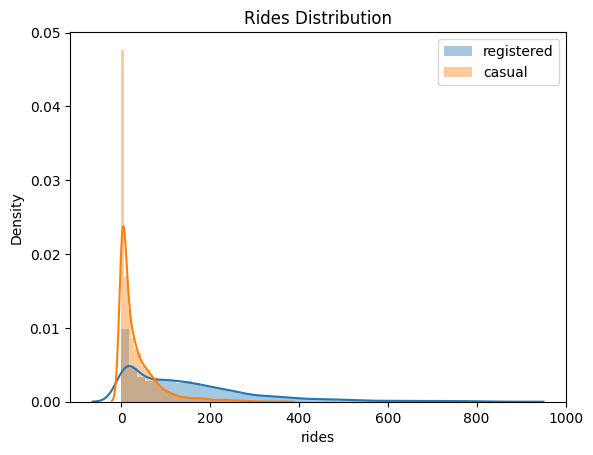

In [4]:
hour_data = pd.read_csv("/content/hour.csv")
print(f"Shape of data {hour_data.shape}")
print(f"Number of missing value {hour_data.isnull().sum().sum()}")

# Statistics in numeric coloumn
print(hour_data.describe().T)

# Based on the document of dataset we are going to convert temporal feature and weather feature into human readable
# format
preprocessed_data = hour_data.copy()

# transforming season
seasonal_mapping = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'}
preprocessed_data['season'] = preprocessed_data['season'].apply(lambda x: seasonal_mapping[x])

# transforming year
year_mapping = {0: 2011, 1: 2012}
preprocessed_data['yr'] = preprocessed_data['yr'].apply(lambda x: year_mapping[x])

# transforming weekday
weekday_mapping = {0: 'sunday', 1: 'monday', 2: 'tuesday', 3: 'wednesday', 4: 'thursday', 5: 'friday', 6: 'thursday'}
preprocessed_data['weekday'] = preprocessed_data['weekday'].apply(lambda x: weekday_mapping[x])

# transforming weather
weathersit_mapping = {1: 'clear', 2: 'cloudy',
                      3: 'light_rain_snow', 4: 'heavy_rain_snow'}
preprocessed_data['weathersit'] = preprocessed_data['weathersit'].apply(lambda x: weathersit_mapping[x])

# rescale the hum and windspeed
preprocessed_data['hum'] = preprocessed_data['hum'] * 100
preprocessed_data['windspeed'] = preprocessed_data['windspeed'] * 67

cols = ['season', 'yr', 'weekday', 'weathersit', 'hum', 'windspeed']
print(preprocessed_data[cols].sample(10, random_state=42))

# plotting distribution for casual and registered
sns.distplot(preprocessed_data['registered'], label='registered')
sns.distplot(preprocessed_data['casual'], label='casual')
plt.legend()
plt.xlabel('rides')
plt.title('Rides Distribution')
plt.show()


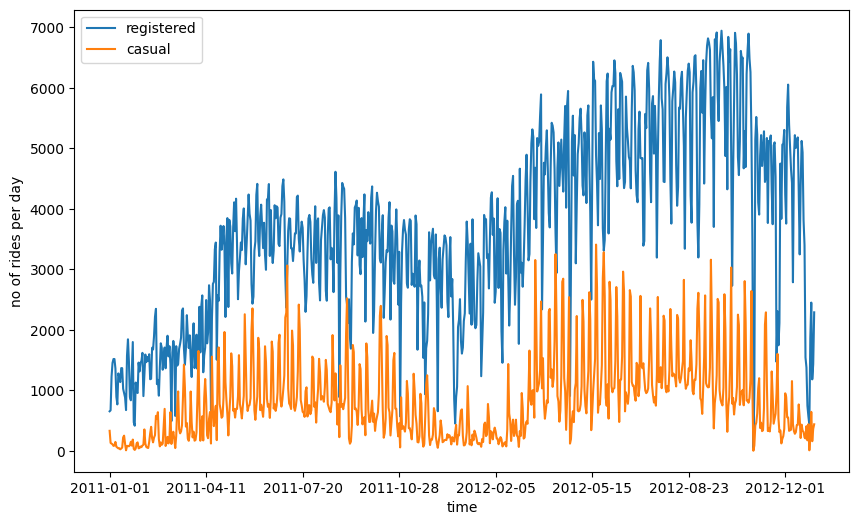

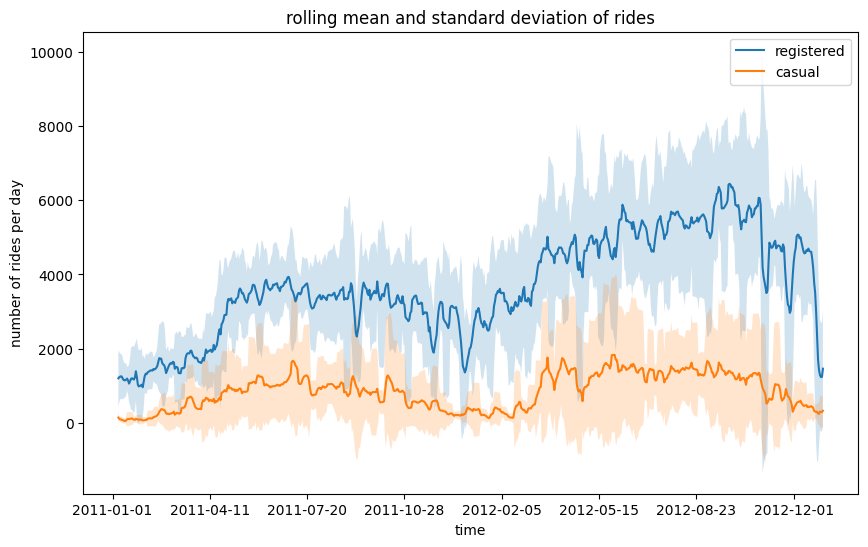

In [5]:
# evolution of rides over time
plot_data = preprocessed_data[['registered', 'casual', 'dteday']]
ax = plot_data.groupby('dteday').sum().plot(figsize=(10, 6))
ax.set_xlabel("time")
ax.set_ylabel("no of rides per day")
plt.show()

# To smooth the curves - rolling mean
plot_datas = preprocessed_data[['registered', 'casual', 'dteday']]
plot_datas = plot_datas.groupby('dteday').sum()

window = 7
rolling_mean = plot_datas.rolling(window).mean()
rolling_std = plot_datas.rolling(window).std()

ax1 = rolling_mean.plot(figsize=(10, 6))
ax1.fill_between(rolling_mean.index, rolling_mean['registered'] + 2 * rolling_std['registered'],
                 rolling_mean['registered'] - 2 * rolling_std['registered'], alpha=0.2)
ax1.fill_between(rolling_mean.index, rolling_mean['casual'] + 2 * rolling_std['casual'],
                 rolling_mean['casual'] - 2 * rolling_std['casual'], alpha=0.2)

ax1.set_xlabel("time")
ax1.set_ylabel("number of rides per day")
plt.title("rolling mean and standard deviation of rides")
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


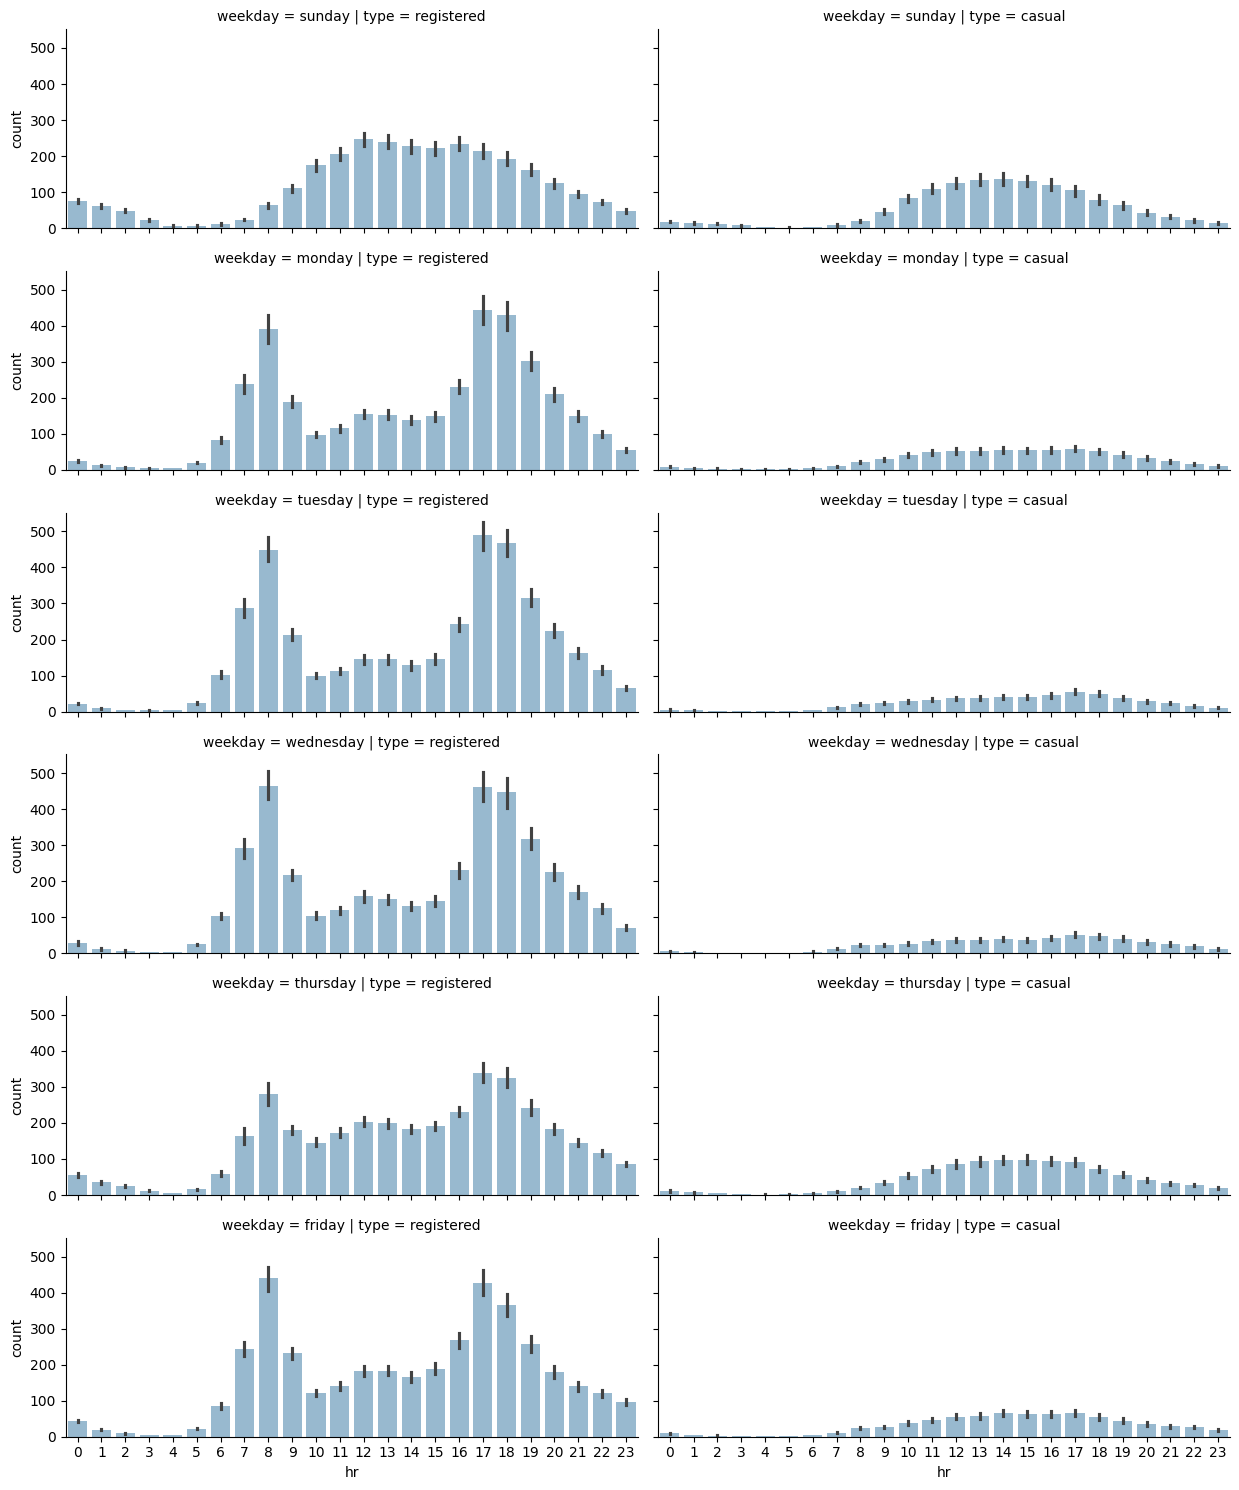

In [6]:
# Plotting for day and week impact on rides
plot_data = preprocessed_data[['hr', 'weekday', 'registered', 'casual']]

plot_data = plot_data.melt(id_vars=['hr', 'weekday'], var_name='type', value_name='count')

grid = sns.FacetGrid(plot_data, row='weekday', col='type', height=2.5,
                     aspect=2.5, row_order=['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday'])

grid.map(sns.barplot, 'hr', 'count', alpha=0.5)
plt.show()


An interesting pattern occurs as we can see decreasing number of riders in weekenss than the rest of weeks but the casual rides are increasing in the weekend, For significant prove we conduct a hypothesis testing


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


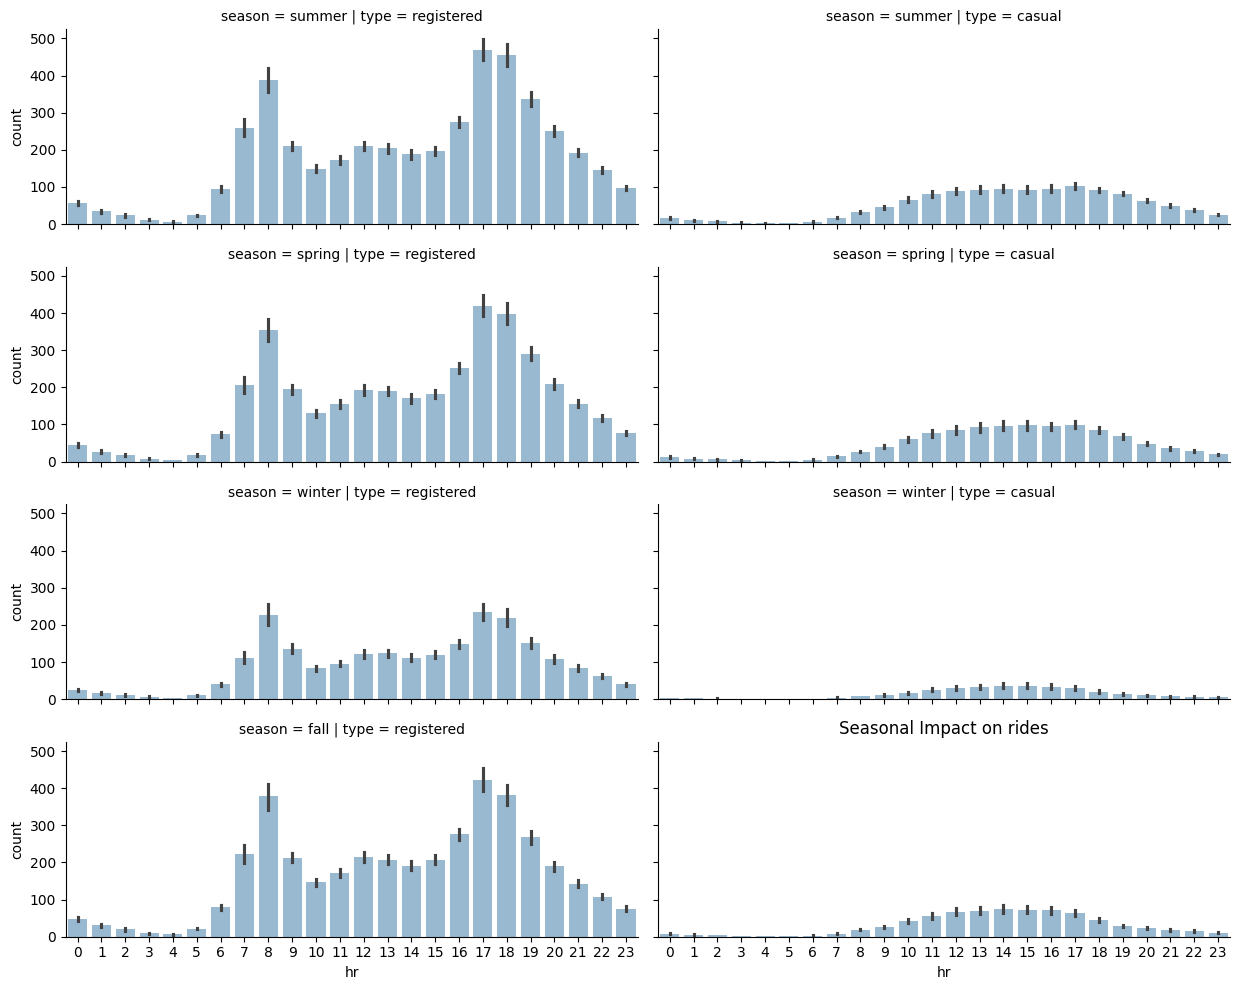

In [7]:
# Analysing seasonal impact on rises:
plot_data = preprocessed_data[['hr', 'season', 'registered', 'casual']]
plot_data = plot_data.melt(id_vars=['hr', 'season'], var_name='type', value_name='count')

grid = sns.FacetGrid(plot_data, row='season', col='type', height=2.5,
                     aspect=2.5, row_order=['summer', 'spring', 'winter', 'fall'])
grid.map(sns.barplot, 'hr', 'count', alpha=0.5)
plt.title("Seasonal Impact on rides")
plt.show()

Hypothesis testing for registered rides

H_0 = Avg registered rides over weekdays-average registerd rides over weekends = 0

H_a = Avg_regstered rides over weekdays-average registered rides over weekend ≠ 0


In [8]:
population_mean = preprocessed_data['registered'].mean()

weekend_days = ['saturday', 'sunday']
weekend_mask = preprocessed_data['weekday'].isin(weekend_days)

working_weeks = ~preprocessed_data['weekday'].isin(weekend_days)

weekend_data = preprocessed_data['registered'][weekend_mask]
workday_data = preprocessed_data['registered'][working_weeks]

# Finding two-sided test as we have two different groups
test_result = ttest_ind(weekend_data, workday_data)
print(f"Statistic value: {test_result[0]:.03f}, p-value: {test_result[1]:.03f}")


Statistic value: -11.647, p-value: 0.000


As a conclusion, p-value is less tha 0.05 we can reject a null hypothesis and confirm our initial observation is right,there is a statistical significant differences between weekend and working day for registers user.


<ipython-input-9-a5f3cb474d95>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(weekend_data, label="Weekend data")
<ipython-input-9-a5f3cb474d95>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(workday_data, label="Workday_data")


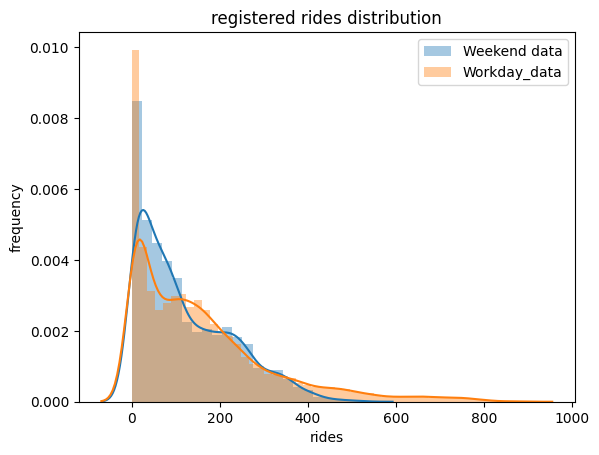

In [9]:

sns.distplot(weekend_data, label="Weekend data")
sns.distplot(workday_data, label="Workday_data")
plt.legend()
plt.xlabel('rides')
plt.ylabel('frequency')
plt.title('registered rides distribution')
plt.show()


Based on second analysis we can conduct a next hypothesis for causal riders

H0 = Avg no of rides during workingdays is same as avg no rides in weekends by casual riders

H_a = Avg no of rides during workingdays is same as avg no rides in weekends by casual riders ≠ 0


 Statistic value: 71.657, p-value: 0.000


<ipython-input-10-add918720f76>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(weekend_data, label="Weekend data")
<ipython-input-10-add918720f76>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(working_days, label="Working days")


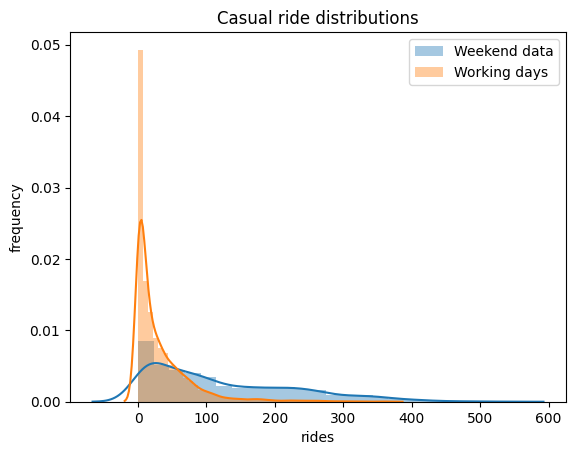

In [10]:
weekend_days = preprocessed_data['casual'][weekend_mask]
working_days = preprocessed_data['casual'][working_weeks]

test_result_casual = ttest_ind(weekend_data, working_days)
print(f" Statistic value: {test_result_casual[0]:.03f}, p-value: {test_result_casual[1]:.03f}")

sns.distplot(weekend_data, label="Weekend data")
sns.distplot(working_days, label="Working days")
plt.legend()
plt.xlabel('rides')
plt.ylabel('frequency')
plt.title("Casual ride distributions")
plt.show()

Analysis of weather related services, is there a bad weather can significantly affect the bike sharing. As both are continuous variable, we can check for correlation


<ipython-input-11-81fe7a44ab16>:11: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


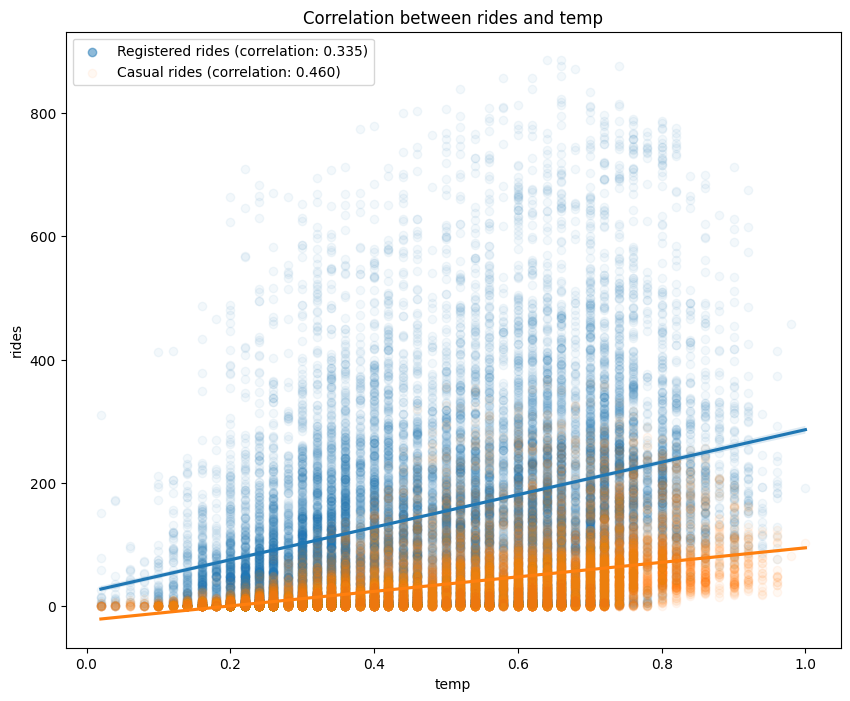

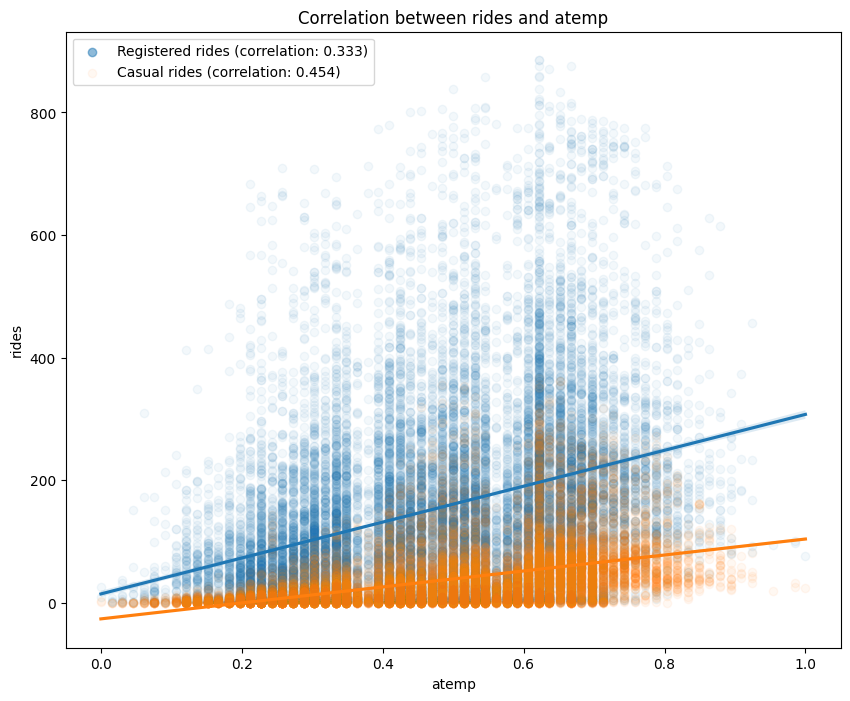

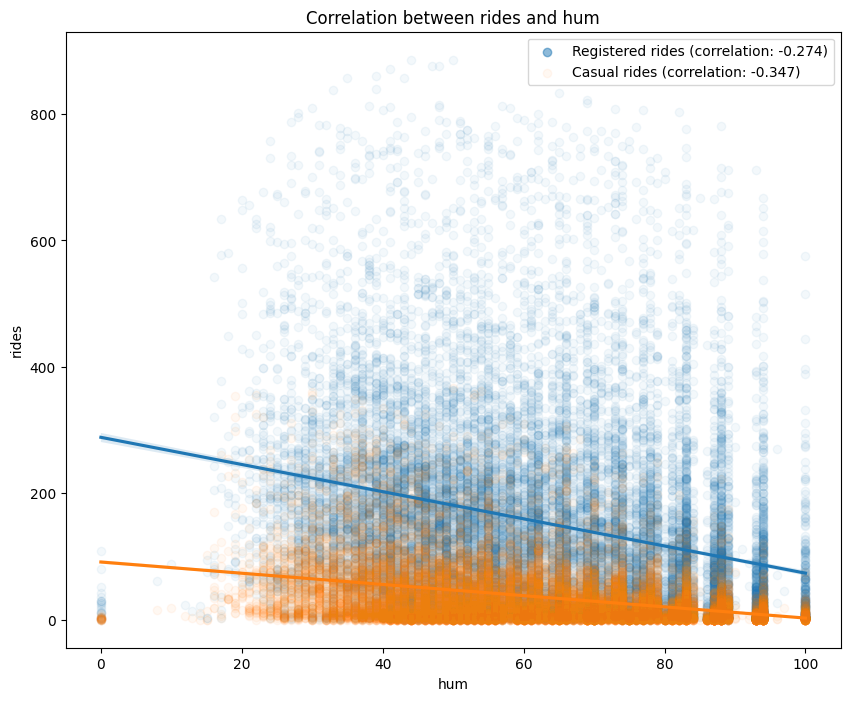

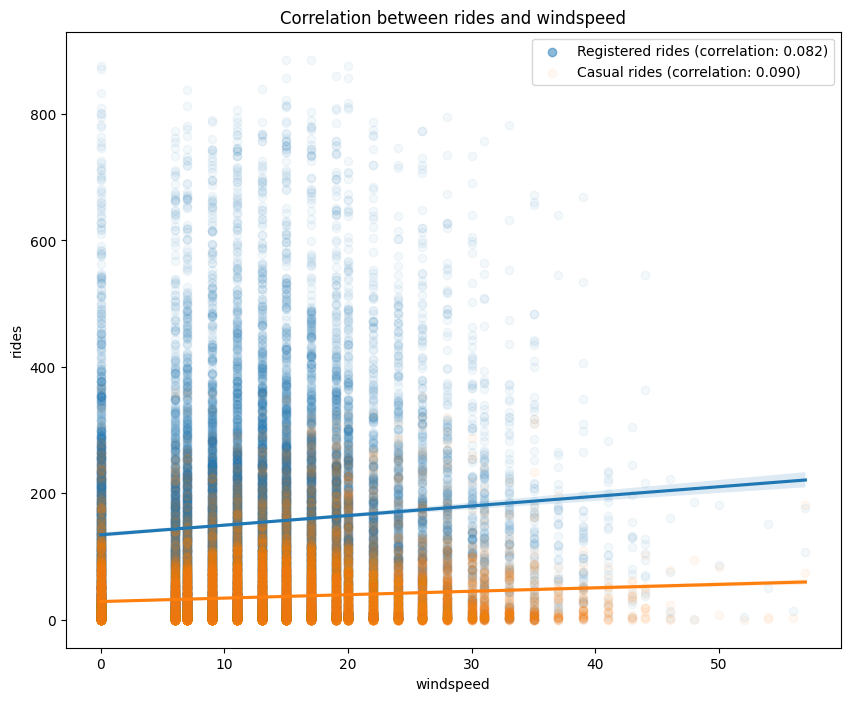

In [11]:
def plot_correlation(data, col):
    corr_registered = np.corrcoef(data[col], data['registered'])[0, 1]
    ax = sns.regplot(x=col, y='registered', data=data, scatter_kws={"alpha": 0.05},
                     label=f"Registered rides (correlation: {corr_registered:.3f})")

    corr_casual = np.corrcoef(data[col], data['casual'])[0, 1]
    ax = sns.regplot(x=col, y='casual', data=data, scatter_kws={"alpha": 0.05},
                     label=f"Casual rides (correlation: {corr_casual:.3f})")

    legend = ax.legend()
    for lh in legend.legendHandles:
        lh.set_alpha(0.5)
        ax.set_ylabel("rides")
        ax.set_title(f"Correlation between rides and {col}")
        return ax


plt.figure(figsize=(10, 8))
ax = plot_correlation(preprocessed_data, 'temp')
plt.show()

plt.figure(figsize=(10, 8))
ax = plot_correlation(preprocessed_data, 'atemp')
plt.show()

plt.figure(figsize=(10, 8))
ax = plot_correlation(preprocessed_data, 'hum')
plt.show()

plt.figure(figsize=(10, 8))
ax = plot_correlation(preprocessed_data, 'windspeed')
plt.show()


Based on the analysis, we can see the higher temperatures have a positive impact on the number of rides.

As the values in the registered column are widely spread with respect to different values in temp, we have a lower correlation compared to casual column.

The high level of humidity and windspeed based on correlation, we can see a negative corelation and customers will tend not to use bike sharing service. We can observe that for windspeed correlation we can conclude there is a minimal corelation between the no of rides and wind speed


In [12]:
def compute_correlations(data, col):
    pearson_registered = pearsonr(data[col], data['registered'])[0]
    pearson_casual = pearsonr(data[col], data['casual'])[0]
    spearman_registered = spearmanr(data[col], data['registered'])[0]
    spearman_casual = spearmanr(data[col], data['casual'])[0]
    return pd.Series({"Pearson (registered)": pearson_registered, "Spearman (registered)": spearman_registered,
                      "Pearson (casual)": pearson_casual, "Spearman (casual)": spearman_casual})


cols = ["temp", "atemp", "hum", "windspeed"]
corr_data = pd.DataFrame(
    index=["Pearson (registered)", "Spearman (registered)", "Pearson (casual)", "Spearman (casual)"])
for col in cols:
    corr_data[col] = compute_correlations(preprocessed_data, col)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(corr_data)

                           temp     atemp       hum  windspeed
Pearson (registered)   0.335361  0.332559 -0.273933   0.082321
Spearman (registered)  0.373196  0.373014 -0.338480   0.122936
Pearson (casual)       0.459616  0.454080 -0.347028   0.090287
Spearman (casual)      0.570989  0.570419 -0.388213   0.122920


Based on the above code, we can strongly conclude that, The casual customers are using bike sharing service when the temperature is higher and registered user is weakly corelate with temperature.


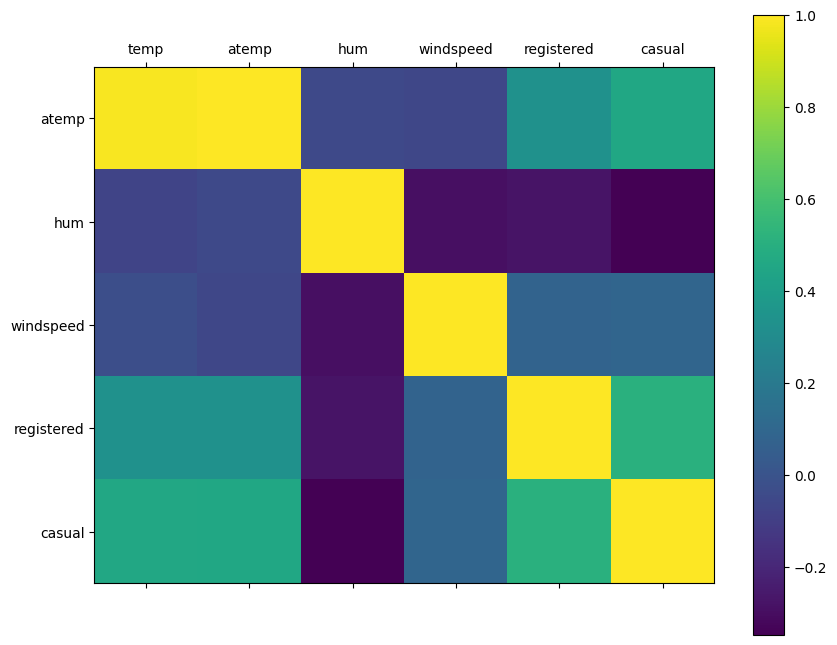

In [13]:
# Corelation matrix
cols = ["temp", "atemp", "hum", "windspeed", "registered", "casual"]
plot_data = preprocessed_data[cols]
corr = plot_data.corr()

fig = plt.figure(figsize=(10, 8))
plt.matshow(corr, fignum=fig.number)
plt.xticks(range(len(plot_data.columns)), plot_data.columns)
plt.yticks(range(len(plot_data.columns)), plot_data.columns)
plt.colorbar()
plt.ylim([5.5, 0.5])
plt.show()

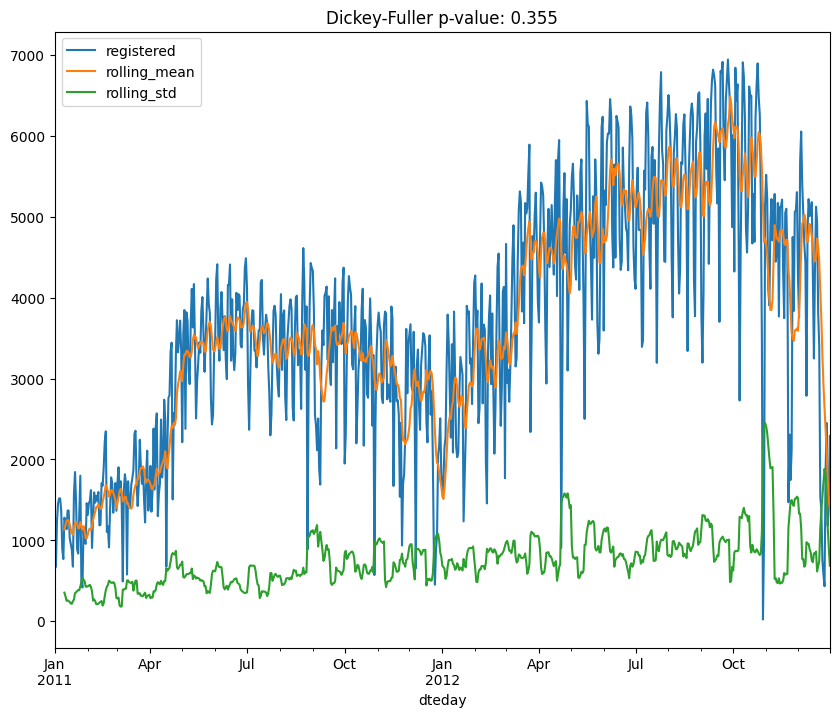

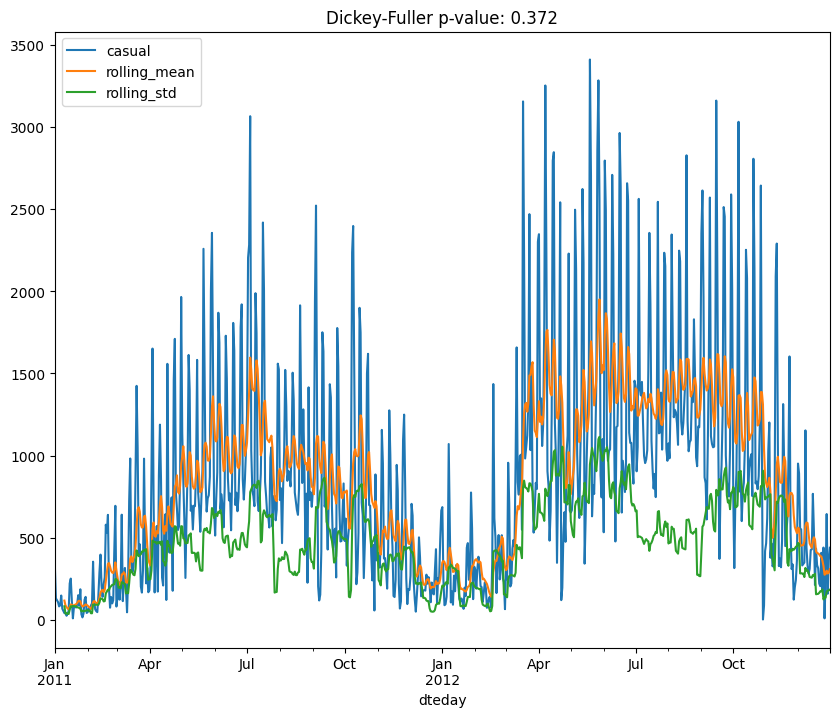

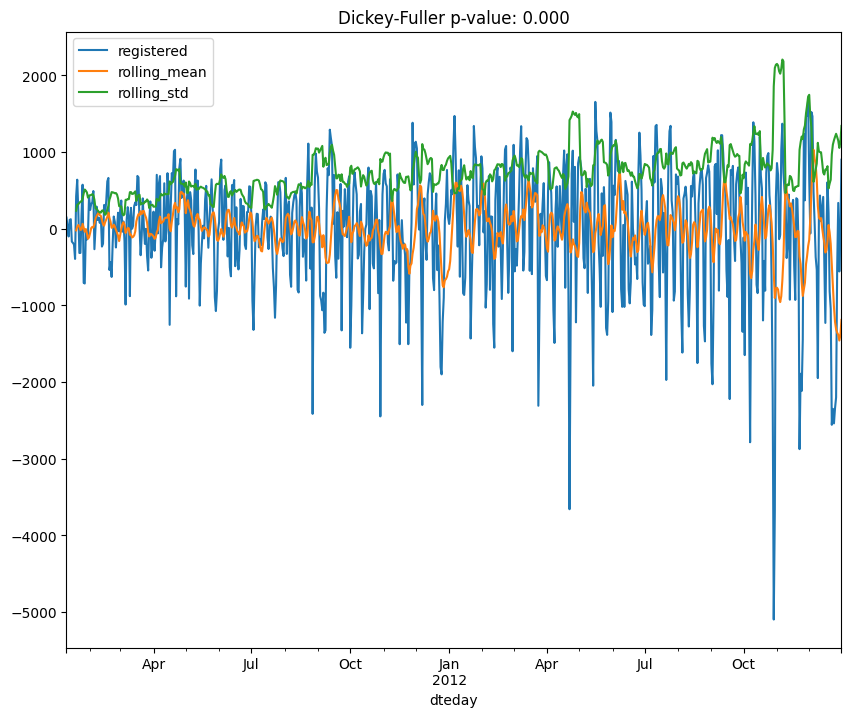

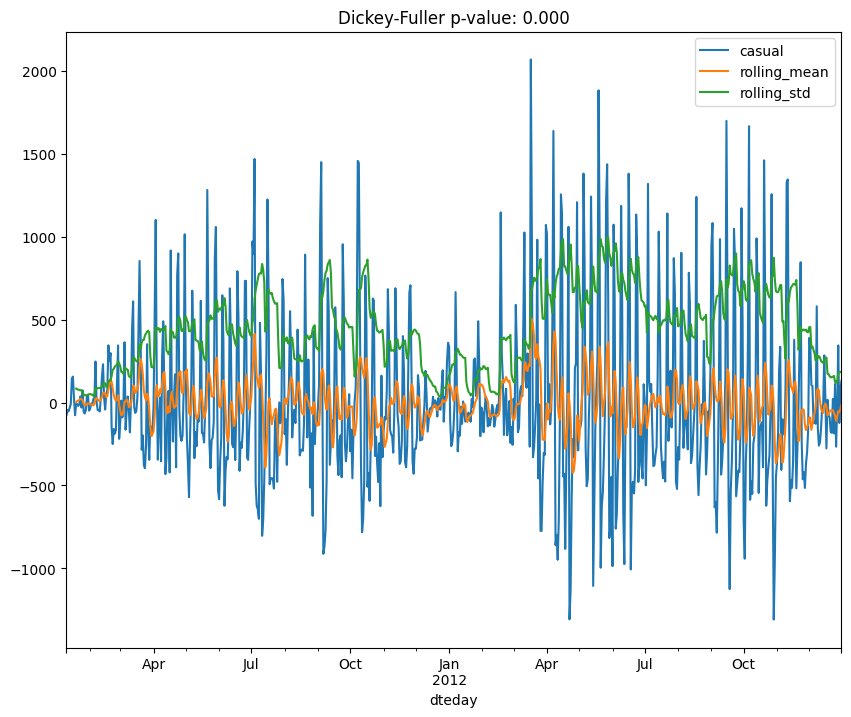

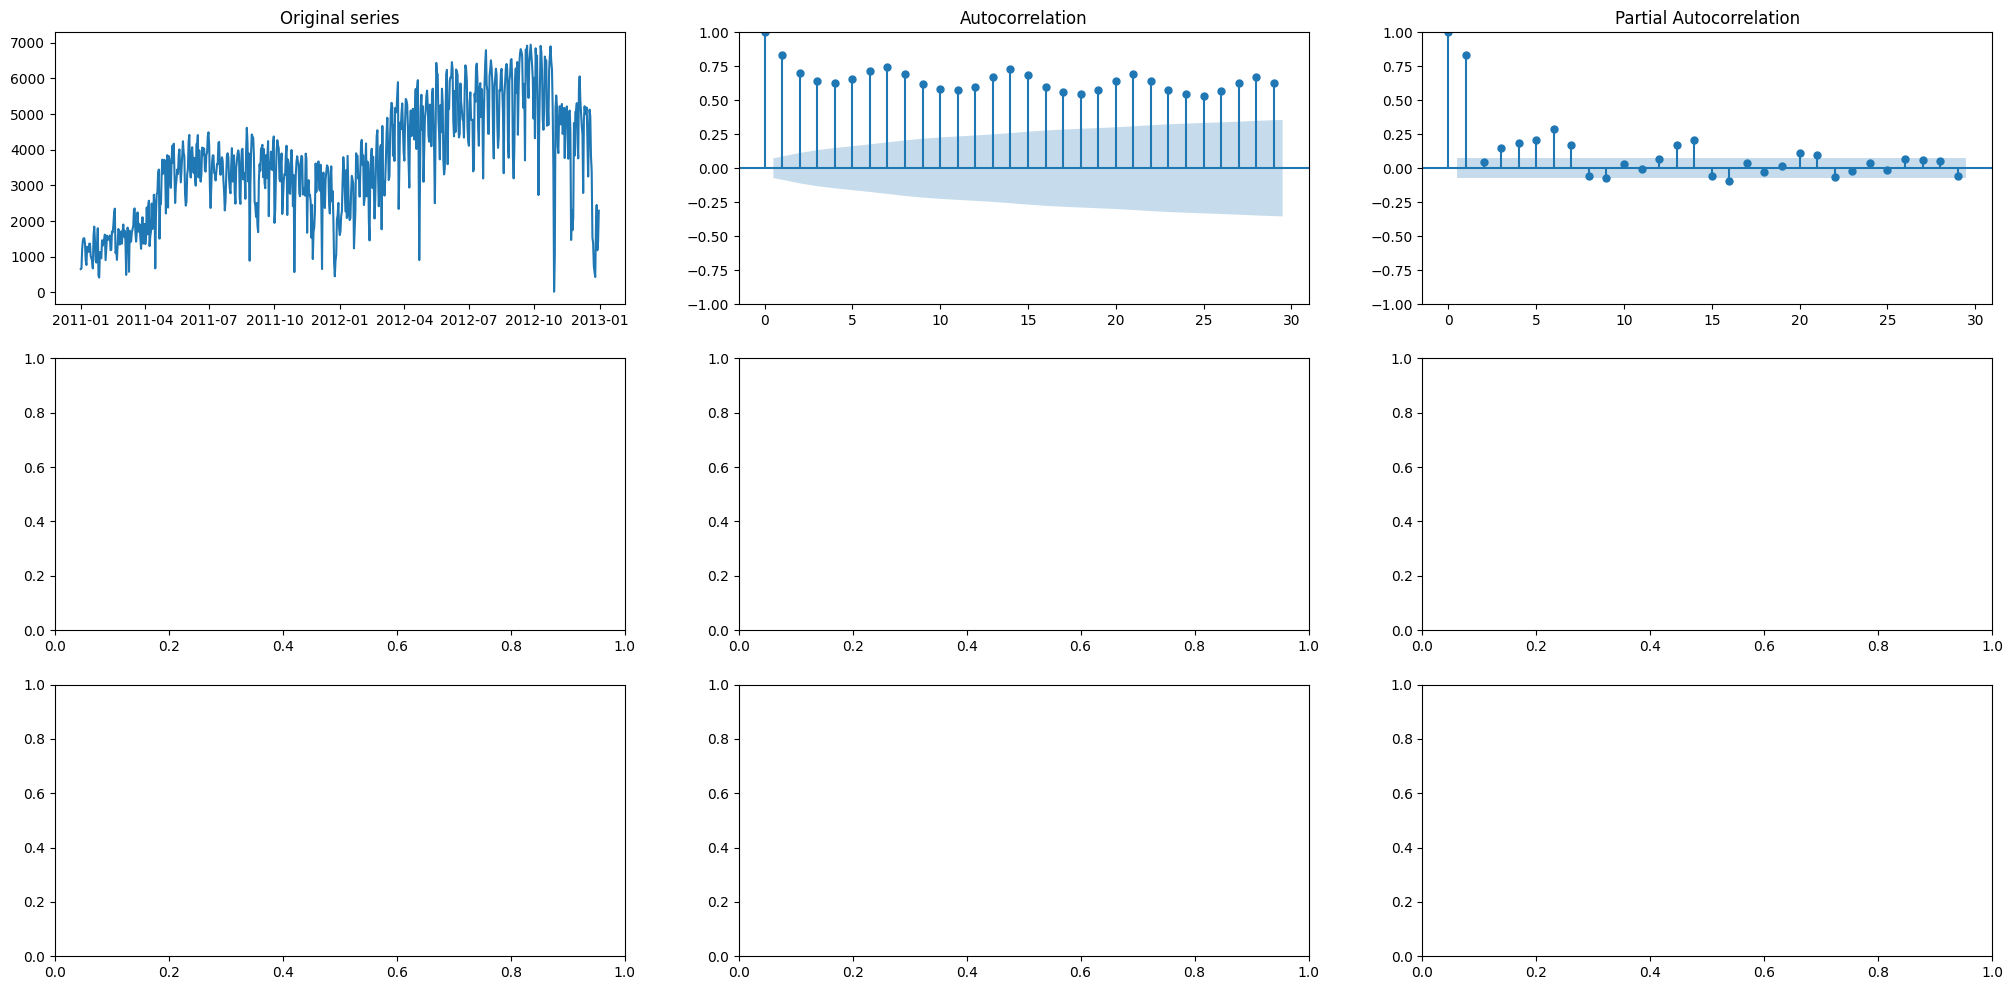

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -5854.522
Date:                Mon, 05 Feb 2024   AIC                          11723.045
Time:                        21:27:52   BIC                          11755.196
Sample:                    01-01-2011   HQIC                         11735.449
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6068      0.050     32.293      0.000       1.509       1.704
ar.L2         -1.4465      0.062    -23.275      0.000      -1.568      -1.325
ar.L3          0.3601      0.049      7.356      0.0

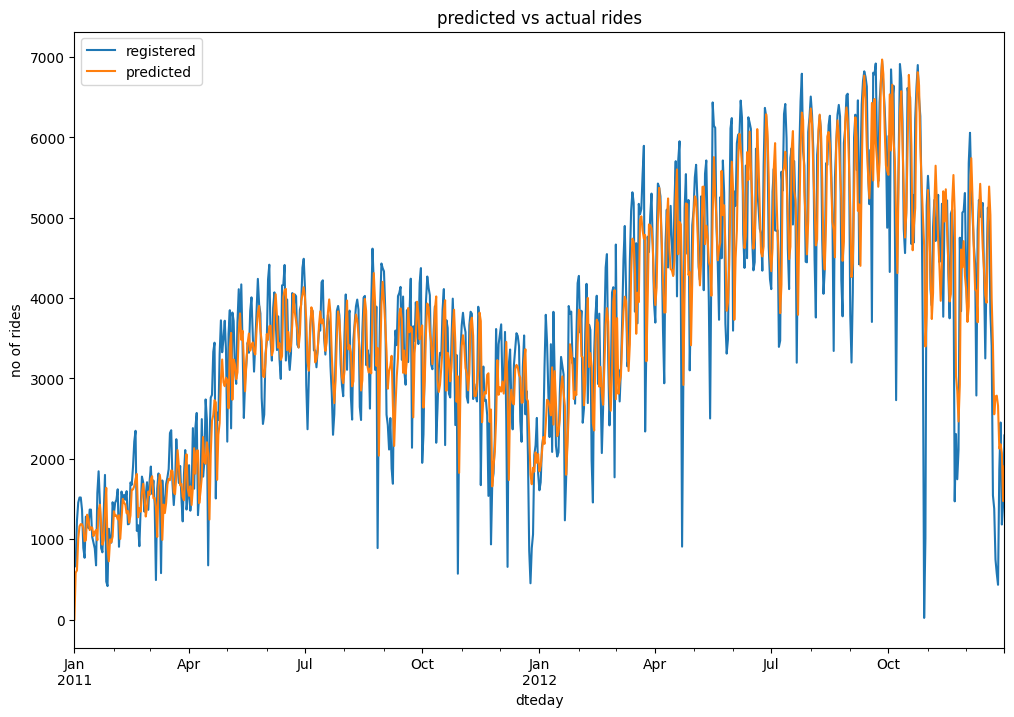

In [14]:
# Time Series plot for riding
def test_stationarity(ts, window=10, **kwargs):
    plot_data = pd.DataFrame(ts)
    plot_data['rolling_mean'] = ts.rolling(window).mean()
    plot_data['rolling_std'] = ts.rolling(window).std()

    p_value = adfuller(ts)[1]
    ax = plot_data.plot(**kwargs)
    ax.set_title(f"Dickey-Fuller p-value: {p_value:.3f}")
    plt.show()


daily_rides = preprocessed_data[["dteday", "registered", "casual"]]
daily_rides = daily_rides.groupby("dteday").sum()
daily_rides.index = pd.to_datetime(daily_rides.index)

test_stationarity(daily_rides['registered'], figsize=(10, 8))
test_stationarity(daily_rides['casual'], figsize=(10, 8))

# To make it stationary, we can either subtract its rolling mean or its last value
registered = daily_rides['registered']
registered_ma = registered.rolling(10).mean()
registered_ma_diff = registered - registered_ma
registered_ma_diff.dropna(inplace=True)

casual = daily_rides['casual']
casual_ma = casual.rolling(10).mean()
casual_ma_diff = casual - casual_ma
casual_ma_diff.dropna(inplace=True)

test_stationarity(registered_ma_diff, figsize=(10, 8))
test_stationarity(casual_ma_diff, figsize=(10, 8))

# Modelling time series - Main thing is to understand that modelling time series is to assume a past observation somehow influence future ones
fig, axes = plt.subplots(3, 3, figsize=(25, 12))

# plot original series
original = daily_rides["registered"]
axes[0, 0].plot(original)
axes[0, 0].set_title("Original series")
plot_acf(original, ax=axes[0, 1])
plot_pacf(original, ax=axes[0, 2])
plt.show()

# plot first order integrated series
first_order_int = original.diff().dropna()
axes[1, 0].plot(first_order_int)
axes[1, 0].set_title("First order integrated")
plot_acf(first_order_int, ax=axes[1, 1])
plot_pacf(first_order_int, ax=axes[1, 2])
plt.show()

# plot second order integrated series
second_order_int = first_order_int.diff().dropna()
axes[2, 0].plot(first_order_int)
axes[2, 0].set_title("Second order integrated")
plot_acf(second_order_int, ax=axes[2, 1])
plot_pacf(second_order_int, ax=axes[2, 2])
plt.show()

model = auto_arima(registered, start_p=1, start_q=1,
                   max_p=3, max_q=3, information_criterion="aic")
print(model.summary())

plot_data = pd.DataFrame(registered)
plot_data['predicted'] = model.predict_in_sample()
plot_data.plot(figsize=(12, 8))
plt.ylabel("no of rides")
plt.title("predicted vs actual rides")
plt.show()
